# Using the Dimensions API to Explore UCSD Research

This notebook explores Dimensions, an API that contains information about research publications, grants, datasets and more. We are specifically interested in research done at UCSD and affliated groups. In this notebook, I explore which publishers are used and collaborations between UCSD and other universities. 

I primarily use Dimcli, a Python client for accessing the Dimensions API, which helps authenticate into the API and handle query requests/responses.

In [2]:
# necessary imports
import dimcli
import pandas as pd
import networkx as nx
import json

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# visualization settings
sns.set_style("white")
sns.set(rc={'figure.figsize':(12, 10)})

In [4]:
# get access with config file. resource: https://digital-science.github.io/dimcli/getting-started.html# 
dimcli.login()

Searching config file credentials for default 'live' instance..


Dimcli - Dimensions API Client (v1.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.9
Method: dsl.ini file


In [5]:
dsl = dimcli.Dsl()

# An Overview of Using Dimcli to Access Dimensions Data

One way to query data is using the dimcli instance to make requests. 

In [47]:
dsl.query("search publications for \"malaria\" return publications limit 1").data # use data attribute to get JSON of info

Returned Publications: 1 (total = 1040585)
Time: 0.61s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


{'_copyright': '© 2024 Digital Science & Research Solutions Inc. All rights reserved. Please refer to our Copyright Notice https://terms.dsrsi.com/public/DimensionsCopyrightNotice for further information.',
 '_stats': {'limit': 1, 'offset': 0, 'total_count': 1040585},
 '_version': {'release': '2.9', 'version': '2.9.1'},
 '_warnings': ['Field current_organization_id of the authors field is deprecated and will be removed in the next major release.'],
 'publications': [{'authors': [{'affiliations': [{'city': 'Wuxi',
       'city_id': 1790923,
       'country': 'China',
       'country_code': 'CN',
       'id': 'grid.452515.2',
       'name': 'Jiangsu Institute of Parasitic Diseases',
       'raw_affiliation': 'Key Laboratory of National Health Commission (NHC) on Parasitic Disease Control and Prevention, Jiangsu Provincial Key Laboratory on Parasite and Vector Control Technology, Jiangsu Institute of Parasitic Diseases, Wuxi, Jiangsu, PR China.',
       'state': None,
       'state_code':

Another way to query information is to use Dimcli magic commands, created specifically for the Jupyter environment, that run faster. This specific command returns a pandas dataframe.

In [7]:
%%dsldf

search publications 
    for "malaria"
return publications [title + research_orgs + research_org_names + times_cited + funders]
limit 5

Returned Publications: 5 (total = 1040585)
Time: 0.59s


,title,funders,research_org_names,research_orgs,times_cited
0,Case-based malaria surveillance and response: ...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...","[Yangzhou University, Nanjing Medical Universi...","[{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...",2
1,Spatio-temporal patterns of malaria in Nepal f...,NaN,[University of Florida],"[{'acronym': 'UF', 'city_name': 'Gainesville',...",1
2,Laboratory diagnosis for malaria in the elimin...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...",[National Institute for Parasitic Diseases],"[{'acronym': 'NIPD', 'city_name': 'Shanghai', ...",12
3,Cross-sectional prevalence and pattern of non-...,NaN,"[MRC Unit the Gambia, Usmanu Danfodiyo Univers...","[{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...",0
4,Trends in malaria indicators after scale-up of...,"[{'acronym': 'NIMH', 'city_name': 'Bethesda', ...","[United Nations Development Programme, Kabul, ...","[{'acronym': 'UCSF', 'city_name': 'San Francis...",2


In [8]:
# all magic commands result stored in..
dsl_last_results.head()

,title,funders,research_org_names,research_orgs,times_cited
0,Case-based malaria surveillance and response: ...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...","[Yangzhou University, Nanjing Medical Universi...","[{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...",2
1,Spatio-temporal patterns of malaria in Nepal f...,NaN,[University of Florida],"[{'acronym': 'UF', 'city_name': 'Gainesville',...",1
2,Laboratory diagnosis for malaria in the elimin...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...",[National Institute for Parasitic Diseases],"[{'acronym': 'NIPD', 'city_name': 'Shanghai', ...",12
3,Cross-sectional prevalence and pattern of non-...,NaN,"[MRC Unit the Gambia, Usmanu Danfodiyo Univers...","[{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...",0
4,Trends in malaria indicators after scale-up of...,"[{'acronym': 'NIMH', 'city_name': 'Bethesda', ...","[United Nations Development Programme, Kabul, ...","[{'acronym': 'UCSF', 'city_name': 'San Francis...",2


# Publications

Let's start querying to do some exploratory data analysis on research done at UCSD. 

In [64]:
GRIDID_LIST = ["grid.266100.3", "grid.413086.8", "grid.420234.3"]
# corresponds to: UCSD, UCSD Medical Center, UCSD Health System
# other possible orgs - Rady's Children hospital, Supercomputer Center

FIELDS = "title+type+year+journal+authors+research_orgs+research_org_names+publisher+times_cited+funders+authors_count"

In [72]:
# search publications from 2024, limit to 300 because of API limits
query = f"""search publications
            where research_orgs.id in {json.dumps(GRIDID_LIST)} and year=2024
            return publications[{FIELDS}] sort by year"""
result = dsl.query(query)

Returned Publications: 20 (total = 3292)
Time: 0.82s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


To get a more accurate understanding, we could iteratively querying over our records. This is because Dimensions has the limit that a single query can't return more than 1000 results.

In [76]:
result = dsl.query_iterative(query, limit=300)

Starting iteration with limit=300 skip=0 ...
0-300 / 3292 (2.52s)
300-600 / 3292 (2.32s)
600-900 / 3292 (6.24s)
900-1200 / 3292 (1.97s)
1200-1500 / 3292 (2.56s)
1500-1800 / 3292 (2.64s)
1800-2100 / 3292 (3.26s)
2100-2400 / 3292 (5.37s)
2400-2700 / 3292 (2.75s)
2700-3000 / 3292 (3.09s)
3000-3292 / 3292 (1.98s)
===
Records extracted: 3292
Warnings:  11


In [82]:
# turn result from Dimcli query into pandas dataframe
pubs = result.as_dataframe()
pubs.head()

,title,authors,research_org_names,research_orgs,times_cited,type,year,journal.id,journal.title,funders,publisher
0,"Social Isolation, Brain Food Cue Processing, E...","[{'affiliations': [{'city': 'Los Angeles', 'ci...","[University of California, Los Angeles, Univer...","[{'acronym': 'UCSD', 'city_name': 'San Diego',...",0,article,2024,jour.1321825,JAMA Network Open,NaN,NaN
1,Associations of Kidney Functional Magnetic Res...,"[{'affiliations': [{'city': 'Evanston', 'city_...","[University of California, San Diego, Universi...","[{'acronym': 'NU', 'city_name': 'Evanston', 'c...",0,article,2024,jour.1381431,Kidney360,"[{'acronym': 'NIAID', 'city_name': 'Bethesda',...",NaN
2,Size-Selective Capturing of Exosomes Using DNA...,"[{'affiliations': [{'city': 'Tokyo', 'city_id'...","[University of California, San Diego, Shanghai...","[{'city_name': 'Shanghai', 'country_code': 'CN...",0,article,2024,jour.1081898,Journal of the American Chemical Society,"[{'acronym': 'JSPS', 'city_name': 'Tokyo', 'co...",American Chemical Society (ACS)
3,Serotonin Syndrome and Dextromethorphan Toxici...,"[{'affiliations': [{'city': 'San Diego', 'city...","[VA San Diego Healthcare System, University of...","[{'acronym': 'VASDHS', 'city_name': 'San Diego...",0,article,2024,jour.1017096,The Journal of Clinical Psychiatry,NaN,"Physicians Postgraduate Press, Inc"
4,Industry Payments to American Society of Hemat...,"[{'affiliations': [{'city': 'Rochester', 'city...","[University of California, San Diego, The Lund...","[{'acronym': 'SBU', 'city_name': 'Stony Brook'...",0,article,2024,jour.1284467,Blood Advances,NaN,American Society of Hematology


## Data Cleaning and Reformatting

After querying from Dimensions, let's organize our data so it is easier to work with. 

In [10]:
# let's do some data processing and reformat the data
# the funders information is given a list of dictionaries, each dictionary represents the info for a funder
pubs['funder_name'] = pubs['funders'].apply(lambda x : [] if isinstance(x, float)
                                            else [dict['name'] for dict in x])

## Publishers

In [11]:
# create dataframe to create an order to sort visualization of publishers
count_publisher = pubs['publisher'].value_counts().reset_index()
# count_publisher = count_publisher[count_publisher['publisher'] > 4] # don't include publishers with <4 UCSD publications
count_publisher.head()

,index,publisher
0,Springer Nature,185
1,Elsevier,116
2,Institute of Electrical and Electronics Engine...,66
3,Wiley,21
4,Association for Computing Machinery (ACM),20


After pulling publications from University of California, San Diego which are about artificial intelligence, let's visualize which journals people are publishing in and which publishers. 

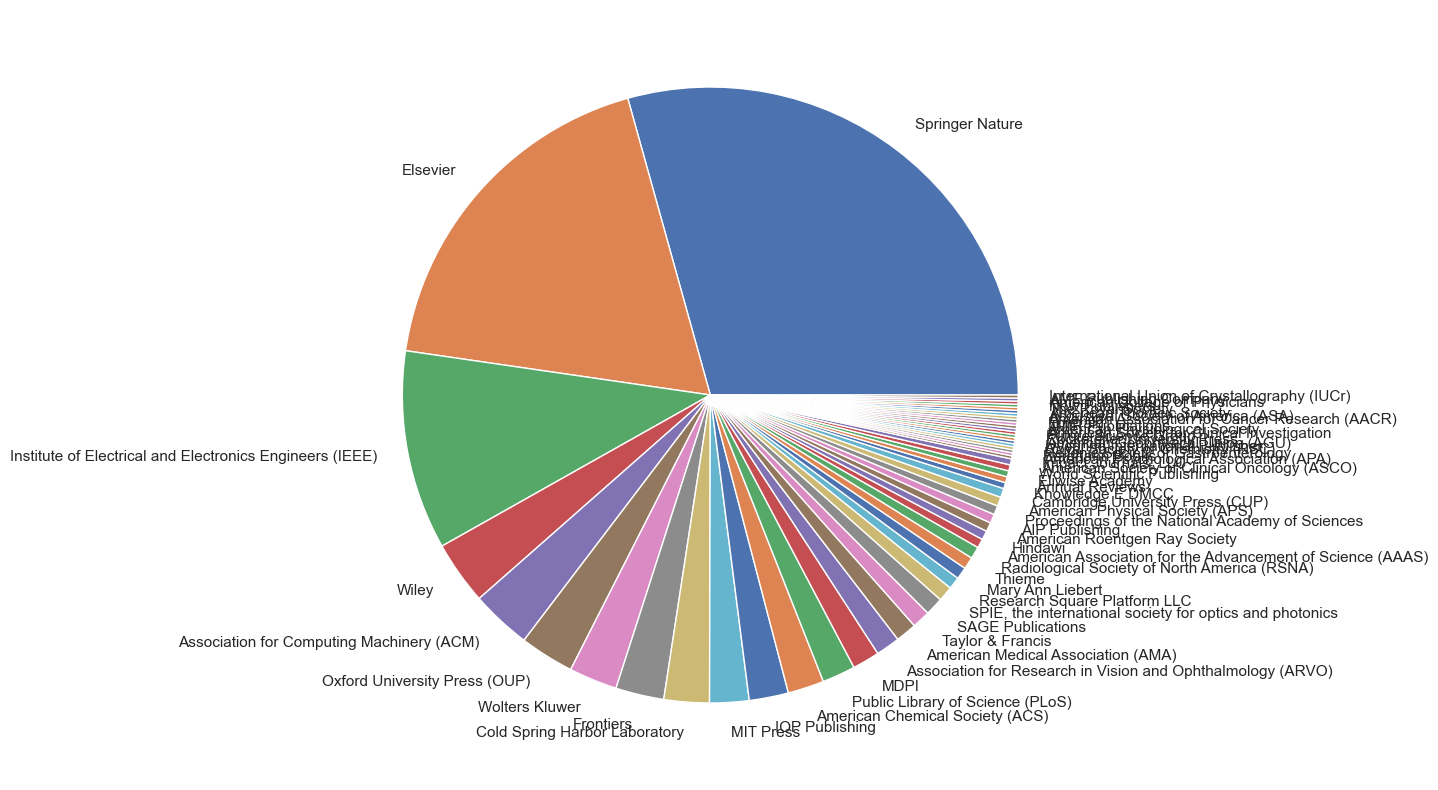

In [12]:
plt.pie(count_publisher['publisher'], labels=count_publisher['index'])
plt.show()

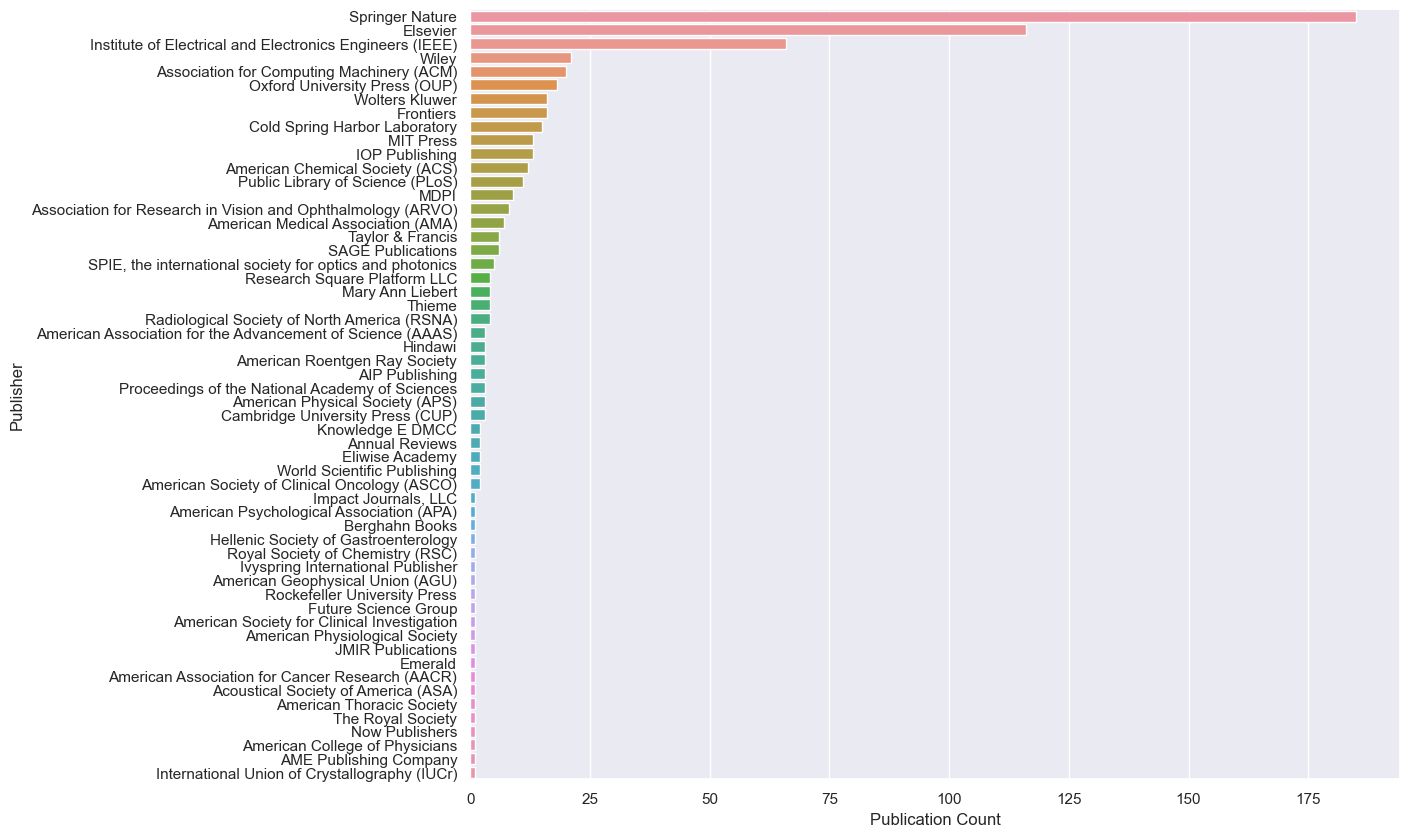

In [13]:
sns.barplot(count_publisher, x="publisher", y="index", order=count_publisher['index'])
plt.xlabel('Publication Count')
plt.ylabel('Publisher')
plt.show()

Which publishers does UCSD have contracts with?...

What topics do the publications write about? Let's get an overview with a word-cloud visualization.

In [14]:
# https://api-lab.dimensions.ai/cookbooks/2-publications/Simple-topic-analysis.html

# Datasets

At UCSD, where are people publishing datasets? 

In [15]:
#%dsldf search datasets for "machine learning" return datasets

# Affliations and Collaborations

In this section, we want to build a network of affliations and collaborations between researchers. We want to look if there are common collaborations cross-university, with implications of building more formal collabortions based on who tends to work together.

In [16]:
ls

['University of Massachusetts Lowell',
 'Sungkyunkwan University',
 'Indian Institute of Technology Madras',
 'Sartorius Corporate Research, Avenue Ariane 5, 1200 Brussels, Belgium.',
 'University of California, San Diego',
 'Imperial College London']

In [26]:
from pyvis.network import Network

got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
got_net.show('example.html', notebook=False)

example.html


In [17]:
# each node is a university. each edge represents number of publications that they have collaborated on 
G = nx.Graph()

In [18]:
# add nodes. takes in a list of universities
def addNodeEdges(ls):
    if 'University of California, San Diego' not in ls:
        print('False')

    for uni in ls: 
        # if uni is UCSD, continue
        # if uni not in graph, add and add edge between UCSD and uni
        # else, increase edge weight of UCSD, uni 
        if uni == 'University of California, San Diego':
            continue

        if uni in G.nodes:
            curr_weight = G.edges[uni, 'University of California, San Diego']['weight']
            G.edges[uni, 'University of California, San Diego']['weight'] = curr_weight + 1
        else:
            G.add_node(uni)
            G.add_edge(uni, 'University of California, San Diego', weight=1)

In [19]:
pubs['research_org_names'].apply(addNodeEdges)

0      None
1      None
2      None
3      None
4      None
       ... 
640    None
641    None
642    None
643    None
644    None
Name: research_org_names, Length: 645, dtype: object

C:\Users\lulennemann\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


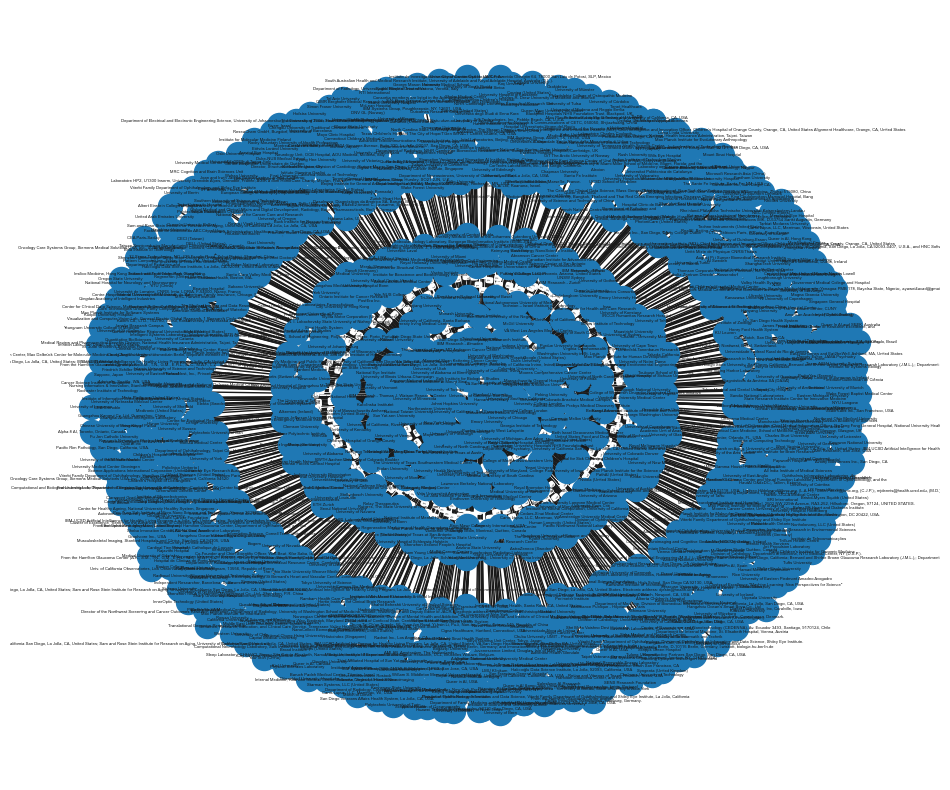

In [20]:
# plot the network of collaborations 
nx.draw_networkx(G, font_size=3)

# add edge labels
pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=3)

plt.axis("off")
plt.show()

In [21]:
# try graph visualization with a different tool...cytoscape and the py4cytoscape library which connects it to Python
import sys
!{sys.executable} -m pip uninstall -y py4cytoscape
!{sys.executable} -m pip install py4cytoscape

'C:\Program' is not recognized as an internal or external command,
operable program or batch file.
'C:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
from pyvis.network import Network
net = Network()
net.from_nx(G)
net.show('nx.html', notebook=False)
net.show_buttons(filter_=['physics'])

nx.html


In [ ]:
query_template = """
    search publications
       where
        research_orgs.id = "{}"
        and research_orgs.id in {}
        and year in [{}:{}]
    return publications[id+doi+type+times_cited+year+authors]
    """

In [ ]:
# normal query
res = dsl.query("search publications for \"artificial-intelligence\" return researchers") # return DslDataset object
[x['first_name'] + " " + x['last_name'] for x in res['researchers']]